In [ ]:
import torch
print(torch.__version__)

2.7.1+cu118


发现 12 个 SOH 文件：
  - processed_Data_Capacity_25C01.csv
  - processed_Data_Capacity_25C02.csv
  - processed_Data_Capacity_25C03.csv
  - processed_Data_Capacity_25C04.csv
  - processed_Data_Capacity_25C05.csv
  - processed_Data_Capacity_25C06.csv
  - processed_Data_Capacity_25C07.csv
  - processed_Data_Capacity_25C08.csv
  - processed_Data_Capacity_35C01.csv
  - processed_Data_Capacity_35C02.csv
  - processed_Data_Capacity_45C01.csv
  - processed_Data_Capacity_45C02.csv
发现 12 个 EIS 文件：
  - EIS_state_V_25C01.csv
  - EIS_state_V_25C02.csv
  - EIS_state_V_25C03.csv
  - EIS_state_V_25C04.csv
  - EIS_state_V_25C05.csv
  - EIS_state_V_25C06.csv
  - EIS_state_V_25C07.csv
  - EIS_state_V_25C08.csv
  - EIS_state_V_35C01.csv
  - EIS_state_V_35C02.csv
  - EIS_state_V_45C01.csv
  - EIS_state_V_45C02.csv
旧数据集形状: (2788, 120)
发现 72 个新电池 Excel 文件
新数据集形状: (72, 120)
旧数据样本数: 2788
新数据样本数: 72
合并后的数据集长度: 2860
训练集长度: 2574 测试集长度: 286
Epoch [0/100], Loss: 0.0177
Epoch [10/100], Loss: 0.0030
Epoch [20/100], Loss: 

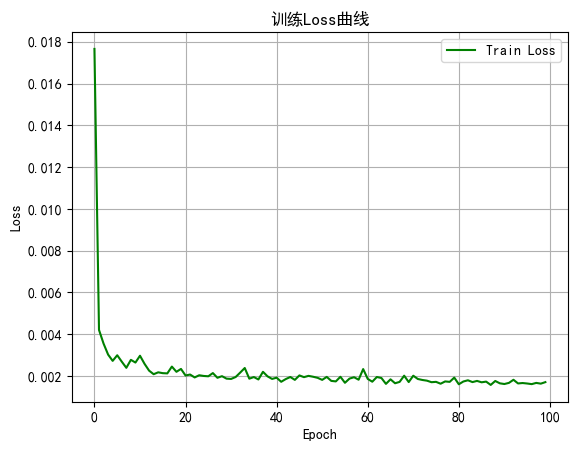

In [ ]:
import os
import re
import glob
import numpy as np
import pandas as pd
import scipy.interpolate as interp
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader, random_split

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def load_soh_data(path_pattern, capacity_base=45):
    soh_dict = {}
    soh_files = glob.glob(path_pattern)
    print(f'发现 {len(soh_files)} 个 SOH 文件：')
    for file in soh_files:
        print(f'  - {os.path.basename(file)}')
    for file in soh_files:
        df = pd.read_csv(file, header=None, skiprows=1)
        for _, row in df.iterrows():
            try:
                cycle = int(row[1])
                soh = float(row[3]) / capacity_base
                soh_dict[cycle] = soh
            except ValueError:
                continue
    return soh_dict

def load_eis_data(path_pattern, soh_dict):
    data_X, data_y = [], []
    eis_files = glob.glob(path_pattern)
    print(f'发现 {len(eis_files)} 个 EIS 文件：')
    for file in eis_files:
        print(f'  - {os.path.basename(file)}')
    for file in eis_files:
        df = pd.read_csv(file, header=None, skiprows=1)
        df = df[[1, 2, 3, 4]]
        df.columns = ['cycle', 'freq', 'Re', 'Im']
        df['log_freq'] = np.log10(df['freq'])
        df['Z_abs'] = np.sqrt(df['Re']**2 + df['Im']**2)
        for cycle, group in df.groupby('cycle'):
            if cycle in soh_dict:
                group_sorted = group.sort_values('log_freq')
                log_f = group_sorted['log_freq'].values
                z_abs = group_sorted['Z_abs'].values
                if len(log_f) != len(z_abs): 
                    continue
                scaler_f = MinMaxScaler()
                scaler_z = MinMaxScaler()
                freq_scaled = scaler_f.fit_transform(log_f.reshape(-1, 1)).flatten()
                z_scaled = scaler_z.fit_transform(z_abs.reshape(-1, 1)).flatten()
                feature_vector = np.concatenate([freq_scaled, z_scaled])
                data_X.append(feature_vector)
                data_y.append(soh_dict[cycle])
    return np.array(data_X), np.array(data_y)

def load_new_excel_data(path_pattern, target_N=60):
    files = glob.glob(path_pattern)
    features = []
    labels = []
    print(f"发现 {len(files)} 个新电池 Excel 文件")
    for file in files:
        filename = os.path.basename(file)
        m = filename.split("_")[1][:-3]
        if not m:
            print(f"无法解析 SOH 数值的文件: {filename}")
            continue
        soh_val = int(m) / 100.0

        df = pd.read_excel(file, header=None)
        if df.shape[1] < 3:
            print(f"文件 {filename} 数据列不足")
            continue
        freq = df.iloc[:, 0].values
        Re = df.iloc[:, 1].values
        Im = df.iloc[:, 2].values

        log_freq = np.log10(freq)
        z_abs = np.sqrt(Re**2 + Im**2)
        
        sort_idx = np.argsort(log_freq)
        log_freq_sorted = log_freq[sort_idx]
        z_abs_sorted = z_abs[sort_idx]

        target_log_freq = np.linspace(log_freq_sorted.min(), log_freq_sorted.max(), target_N)
        interp_fun = interp.interp1d(log_freq_sorted, z_abs_sorted, kind='linear', fill_value='extrapolate')
        z_interp = interp_fun(target_log_freq)

        scaler_f_local = MinMaxScaler()
        scaler_z_local = MinMaxScaler()
        log_freq_scaled = scaler_f_local.fit_transform(target_log_freq.reshape(-1, 1)).flatten()
        z_scaled = scaler_z_local.fit_transform(z_interp.reshape(-1, 1)).flatten()

        feature_vector = np.concatenate([log_freq_scaled, z_scaled])
        features.append(feature_vector)
        labels.append(soh_val)
    return np.array(features), np.array(labels)

soh_dict = load_soh_data('processed_data_Capacity_*.csv')
X_old, y_old = load_eis_data('EIS_state_V_*.csv', soh_dict)
print("旧数据集形状:", X_old.shape)


X_new, y_new = load_new_excel_data("Cell*_*SOH_*degC_95SOC_*.xls", target_N=60)
print("新数据集形状:", X_new.shape)

dataset_old = TensorDataset(
    torch.tensor(X_old, dtype=torch.float32),
    torch.tensor(y_old, dtype=torch.float32).view(-1, 1)
)
dataset_new = TensorDataset(
    torch.tensor(X_new, dtype=torch.float32),
    torch.tensor(y_new, dtype=torch.float32).view(-1, 1)
)
print("旧数据样本数:", len(dataset_old))
print("新数据样本数:", len(dataset_new))

combined_dataset = ConcatDataset([dataset_old, dataset_new])
print("合并后的数据集长度:", len(combined_dataset))

torch.manual_seed(42)

dataset_length = len(combined_dataset)
test_length = int(0.1 * dataset_length)
train_length = dataset_length - test_length
train_dataset, test_dataset = random_split(combined_dataset, [train_length, test_length])
print("训练集长度:", len(train_dataset), "测试集长度:", len(test_dataset))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_params = {
    'hidden_size': 1024,
    'learning_rate': 0.001,
    'dropout_rate': 0.17
}

class SOH_FCNN(nn.Module):
    def __init__(self, input_dim):
        super(SOH_FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, best_params['hidden_size'])
        self.fc2 = nn.Linear(best_params['hidden_size'], best_params['hidden_size'] // 2)
        self.fc3 = nn.Linear(best_params['hidden_size'] // 2, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(best_params['dropout_rate'])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_dim = X_old.shape[1]
model = SOH_FCNN(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_features.size(0)
    avg_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item() * batch_features.size(0)
test_loss /= len(test_dataset)
print(f'Test Loss: {test_loss:.4f}')

torch.save(model.state_dict(), "merged_model.pth")
print("模型已保存为 merged_model.pth")

plt.plot(train_losses, label='Train Loss',color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练Loss曲线')
plt.legend()
plt.grid(True)
plt.show()

Cycle 1: SOH Loss = -0.0716
Cycle 2: SOH Loss = -0.0241
Cycle 3: SOH Loss = -0.0564
Cycle 4: SOH Loss = 0.0008
Cycle 5: SOH Loss = -0.0289
Cycle 6: SOH Loss = -0.0223
Cycle 7: SOH Loss = 0.0074
Cycle 8: SOH Loss = 0.0039
Cycle 9: SOH Loss = -0.0501
Cycle 10: SOH Loss = -0.0220
Cycle 11: SOH Loss = -0.0219
Cycle 12: SOH Loss = 0.0458
Cycle 13: SOH Loss = -0.0219
Cycle 14: SOH Loss = -0.0584
Cycle 15: SOH Loss = 0.0521
Cycle 16: SOH Loss = -0.0192
Cycle 17: SOH Loss = -0.0198
Cycle 18: SOH Loss = -0.0337
Cycle 19: SOH Loss = -0.0339
Cycle 20: SOH Loss = -0.0441
Cycle 21: SOH Loss = 0.0035
Cycle 22: SOH Loss = 0.0069
Cycle 23: SOH Loss = -0.0105
Cycle 24: SOH Loss = -0.0360
Cycle 25: SOH Loss = -0.0240
Cycle 26: SOH Loss = -0.0189
Cycle 27: SOH Loss = -0.0355
Cycle 28: SOH Loss = -0.0588
Cycle 29: SOH Loss = -0.0409
Cycle 30: SOH Loss = -0.0127
Cycle 31: SOH Loss = -0.0271
Cycle 32: SOH Loss = -0.0310
Cycle 33: SOH Loss = 0.0570
Cycle 34: SOH Loss = -0.0379
Cycle 35: SOH Loss = -0.0290
Cy

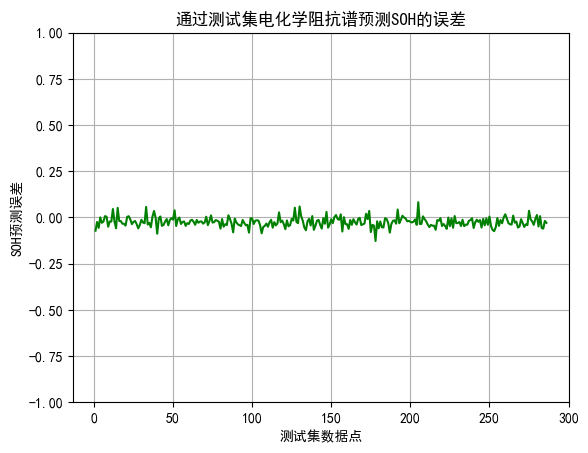

In [3]:
X_train = []
y_train = []
for x, y in train_dataset:
    X_train.append(x.numpy())
    y_train.append(y.numpy())
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []
for x, y in test_dataset:
    X_test.append(x.numpy())
    y_test.append(y.numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).numpy().flatten()
    true_values = y_test_tensor.numpy().flatten()
    cycle_loss = test_outputs - true_values

for i, loss in enumerate(cycle_loss):
    print(f'Cycle {i + 1}: SOH Loss = {loss:.4f}')

plt.plot(range(1, len(cycle_loss) + 1), cycle_loss, linestyle='-', color='g')
plt.xlabel('测试集数据点')
plt.ylabel('SOH预测误差')
plt.title('通过测试集电化学阻抗谱预测SOH的误差')
plt.ylim(-1,1)
plt.grid(True)
plt.savefig('loss.png')
plt.show()

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).numpy().flatten()
    true_values = y_test_tensor.numpy().flatten()

mae = mean_absolute_error(true_values, test_outputs)
mse = mean_squared_error(true_values, test_outputs)
rmse = np.sqrt(mse)

print(f"测试集 MAE: {mae:.4f}")
print(f"测试集 MSE: {mse:.4f}")
print(f"测试集 RMSE: {rmse:.4f}")


测试集 MAE: 0.0304
测试集 MSE: 0.0013
测试集 RMSE: 0.0365


In [23]:
import joblib
import pandas as pd
import numpy as np
import scipy.interpolate as interp
from sklearn.preprocessing import MinMaxScaler
import torch

data = pd.read_csv("j2.csv")

freq = data["Frequency(Hz)"].values
Re  = data["IC(Re)"].values
Im  = data["IC(-Im)"].values               

log_freq = np.log10(freq)
z_abs = np.sqrt(Re**2 + Im**2)

sort_idx = np.argsort(log_freq)
log_freq_sorted = log_freq[sort_idx]
z_abs_sorted    = z_abs[sort_idx]

target_N =  X_train.shape[1] // 2

target_log_freq = np.linspace(log_freq_sorted.min(), log_freq_sorted.max(), target_N)


z_abs_interp = interp.interp1d(log_freq_sorted, z_abs_sorted, kind='linear', fill_value="extrapolate")(target_log_freq)

scaler_f = MinMaxScaler()
freq_scaled = scaler_f.fit_transform(target_log_freq.reshape(-1, 1)).flatten()

scaler_z = MinMaxScaler()
z_scaled = scaler_z.fit_transform(z_abs_interp.reshape(-1, 1)).flatten()

joblib.dump(scaler_f, 'scaler_f.pkl')
joblib.dump(scaler_z, 'scaler_z.pkl')

new_feature_vector = np.concatenate([freq_scaled, z_scaled])

x_new = torch.tensor(new_feature_vector, dtype=torch.float32).unsqueeze(0)

model.eval()
with torch.no_grad():
    pred_norm = model(x_new)

pred_norm_value = pred_norm.item()

print(f"预测 SOH 约为: {pred_norm_value*100:.2f}%")

freq_list = [36.8275, 71.9448, 89.9378, 175.6990, 219.6402,
             343.2391, 429.0810, 536.3913, 670.5392, 838.2366, 1047.8740, 0.0889]

预测的归一化 SOH: 0.9198
若以新电池额定 1500 mAh 为满健康，预测 SOH 约为: 91.98%
预测的归一化 SOH: 0.9276
若以新电池额定 1500 mAh 为满健康，预测 SOH 约为: 92.76%
预测的归一化 SOH: 0.9321
若以新电池额定 1500 mAh 为满健康，预测 SOH 约为: 93.21%
目标频率:    36.8275 -> 匹配频率:    36.2397, Re: 51548.9620, -Im: 2798.1810
目标频率:    71.9448 -> 匹配频率:    72.4794, Re: 50100.5940, -Im: 3013.1670
目标频率:    89.9378 -> 匹配频率:    89.6456, Re: 49665.6790, -Im: 3046.1680
目标频率:   175.6990 -> 匹配频率:   175.4765, Re: 48298.9150, -Im: 3083.2410
目标频率:   219.6402 -> 匹配频率:   219.3457, Re: 47809.1640, -Im: 3070.3950
目标频率:   343.2391 -> 匹配频率:   343.3236, Re: 46910.5190, -Im: 2945.2440
目标频率:   429.0810 -> 匹配频率:   427.2472, Re: 46424.1310, -Im: 2863.7400
目标频率:   536.3913 -> 匹配频率:   534.0590, Re: 45975.2480, -Im: 2662.4960
目标频率:   670.5392 -> 匹配频率:   671.3885, Re: 45490.4510, -Im: 2425.8910
目标频率:   838.2366 -> 匹配频率:   839.2356, Re: 45006.2740, -Im: 2135.1800
目标频率:  1047.8740 -> 匹配频率:  1052.8592, Re: 44518.7170, -Im: 1722.6620
目标频率:     0.0889 -> 匹配频率:     0.0596, Re: 59921.1490, -Im: 5744.

In [12]:
freq_scaled = new_feature_vector[:target_N]
z_scaled = new_feature_vector[target_N:]

gradient = np.abs(np.gradient(z_scaled))

top_k = 20
top_indices = np.argsort(gradient)[-top_k:]
top_indices_sorted = np.sort(top_indices)

selected_log_freq = target_log_freq[top_indices_sorted]
selected_freq = 10 ** selected_log_freq
selected_z_scaled = z_scaled[top_indices_sorted]

print(f"{'Index':>5} {'Frequency(Hz)':>15} {'log10(Freq)':>15} {'Z_abs (scaled)':>15}")
print("-" * 55)
for i, idx in enumerate(top_indices_sorted):
    print(f"{idx:5d} {selected_freq[i]:15.4f} {selected_log_freq[i]:15.4f} {selected_z_scaled[i]:15.4f}")


Index   Frequency(Hz)     log10(Freq)  Z_abs (scaled)
-------------------------------------------------------
    0          0.0149         -1.8268          1.0000
    1          0.0186         -1.7299          0.9579
    2          0.0233         -1.6329          0.9158
    3          0.0291         -1.5360          0.8737
    4          0.0364         -1.4390          0.8456
    5          0.0455         -1.3421          0.8190
    6          0.0569         -1.2452          0.7925
    7          0.0711         -1.1482          0.7699
    8          0.0889         -1.0513          0.7484
   35         36.8275          1.5662          0.4058
   38         71.9448          1.8570          0.3448
   39         89.9378          1.9539          0.3245
   42        175.6990          2.2448          0.2644
   43        219.6402          2.3417          0.2427
   45        343.2391          2.5356          0.2027
   46        429.0810          2.6325          0.1809
   47        536.3913     

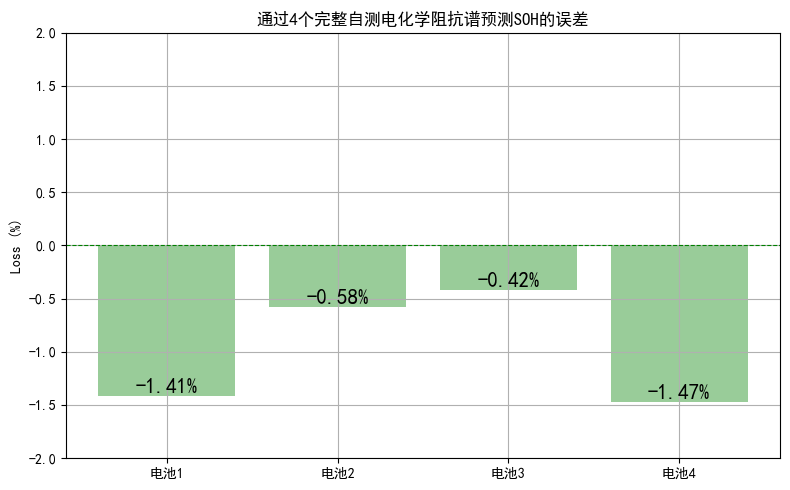

In [36]:
import matplotlib.pyplot as plt
import numpy as np

samples = ['电池1', '电池2', '电池3', '电池4']
predicted_soh = np.array([91.98, 92.76, 93.21, 92.22])
actual_soh = np.array([93.3, 93.3, 93.6, 93.6])

error_percent = (predicted_soh - actual_soh) / actual_soh * 100

plt.figure(figsize=(8, 5))
bars = plt.bar(samples, error_percent, color='green', alpha=0.4)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom',fontsize=15)

plt.axhline(y=0, color='green', linestyle='--', linewidth=0.8)
plt.title('通过4个完整自测电化学阻抗谱预测SOH的误差')
plt.ylabel('Loss (%)')
plt.ylim(-2,2)
plt.grid()
plt.tight_layout()
plt.savefig('sample_loss')
plt.show()

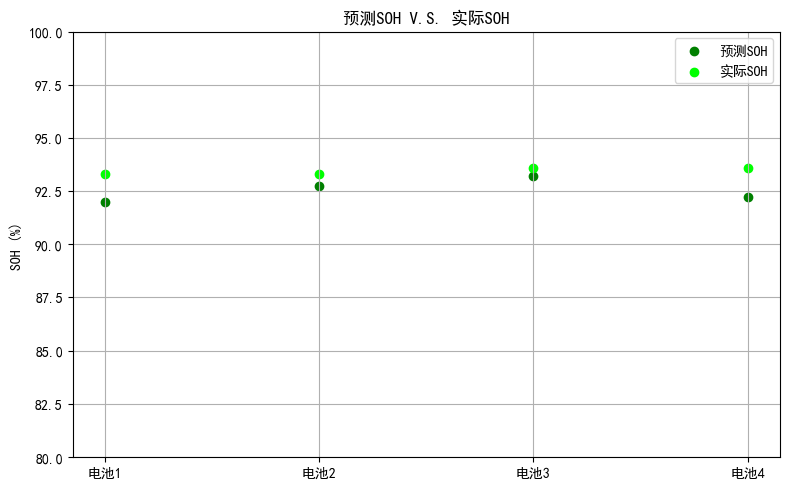

In [37]:
import matplotlib.pyplot as plt
import numpy as np

samples = ['电池1', '电池2', '电池3', '电池4']
predicted_soh = np.array([91.98, 92.76, 93.21, 92.22])
actual_soh = np.array([93.3, 93.3, 93.6, 93.6])

plt.figure(figsize=(8, 5))

plt.scatter(samples,predicted_soh, label='预测SOH',color='g')
plt.scatter(samples,actual_soh, label='实际SOH',color='lime')
plt.legend()


plt.title('预测SOH V.S. 实际SOH')
plt.ylabel('SOH (%)')
plt.grid()
plt.ylim(80,100)
plt.tight_layout()
plt.savefig('comparison_soh')
plt.show()

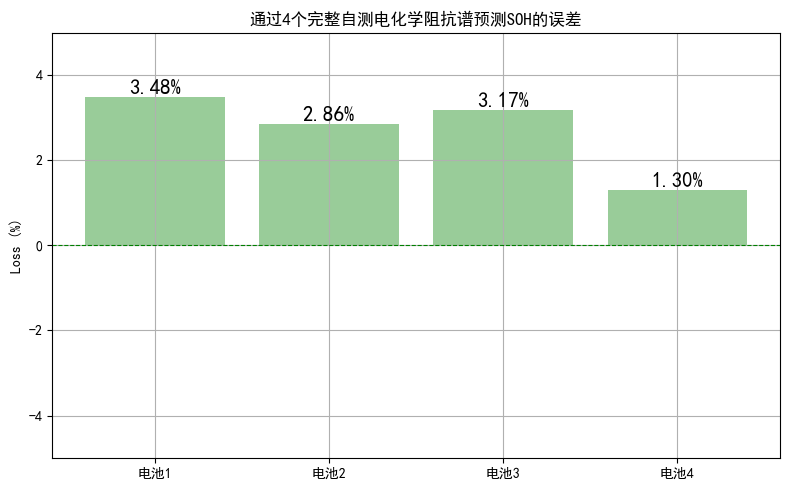

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


samples = ['电池1', '电池2', '电池3', '电池4']
predicted_soh = np.array([96.55, 95.97, 96.57, 94.82])
actual_soh = np.array([93.3, 93.3, 93.6, 93.6])

error_percent = (predicted_soh - actual_soh) / actual_soh * 100

plt.figure(figsize=(8, 5))
bars = plt.bar(samples, error_percent, color='green', alpha=0.4)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom',fontsize=15)

plt.axhline(y=0, color='green', linestyle='--', linewidth=0.8)
plt.title('通过4个完整自测电化学阻抗谱预测SOH的误差')
plt.ylabel('Loss (%)')
plt.ylim(-5,5)
plt.grid()
plt.tight_layout()
plt.savefig('sample_loss_few')
plt.show()

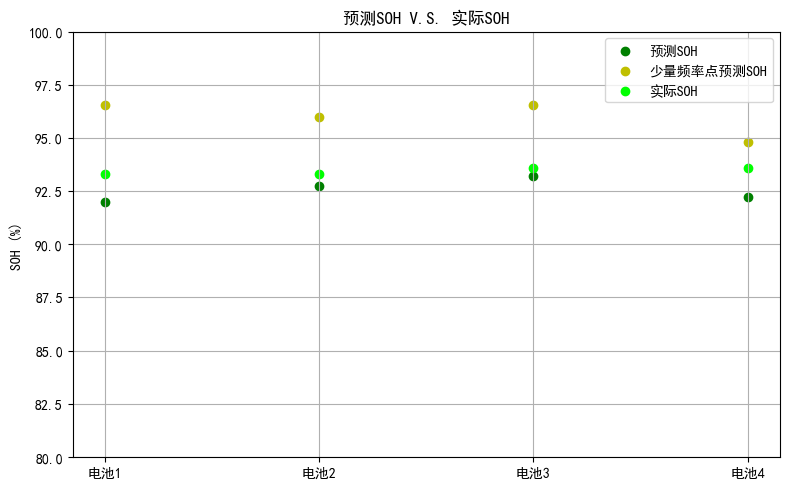

In [35]:
import matplotlib.pyplot as plt
import numpy as np

samples = ['电池1', '电池2', '电池3', '电池4']
predicted_soh_few = np.array([96.55, 95.97, 96.57, 94.82])
predicted_soh = np.array([91.98, 92.76, 93.21, 92.22])
actual_soh = np.array([93.3, 93.3, 93.6, 93.6])

plt.figure(figsize=(8, 5))

plt.scatter(samples,predicted_soh, label='预测SOH',color='g')
plt.scatter(samples,predicted_soh_few, label='少量频率点预测SOH',color='y')
plt.scatter(samples,actual_soh, label='实际SOH',color='lime')
plt.legend()


plt.title('预测SOH V.S. 实际SOH')
plt.ylabel('SOH (%)')
plt.grid()
plt.ylim(80,100)
plt.tight_layout()
plt.savefig('comparison_soh_few')
plt.show()